# Tutorial VI: Recurrent Neural Networks

<p>
Bern Winter School on Machine Learning, 28.01-01.02 2019<br>
Mykhailo Vladymyrov
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will see what RNN is. We will use it to predict/generate text sequence, but same approach can be applied to any sequential data.


(Largely adopted from `https://github.com/roatienza/Deep-Learning-Experiments`)

So far we looked at the data available altogether. In many cases the data is sequential (weather, speach, sensor signals etc).
RNNs are specifically designed for such tasks.

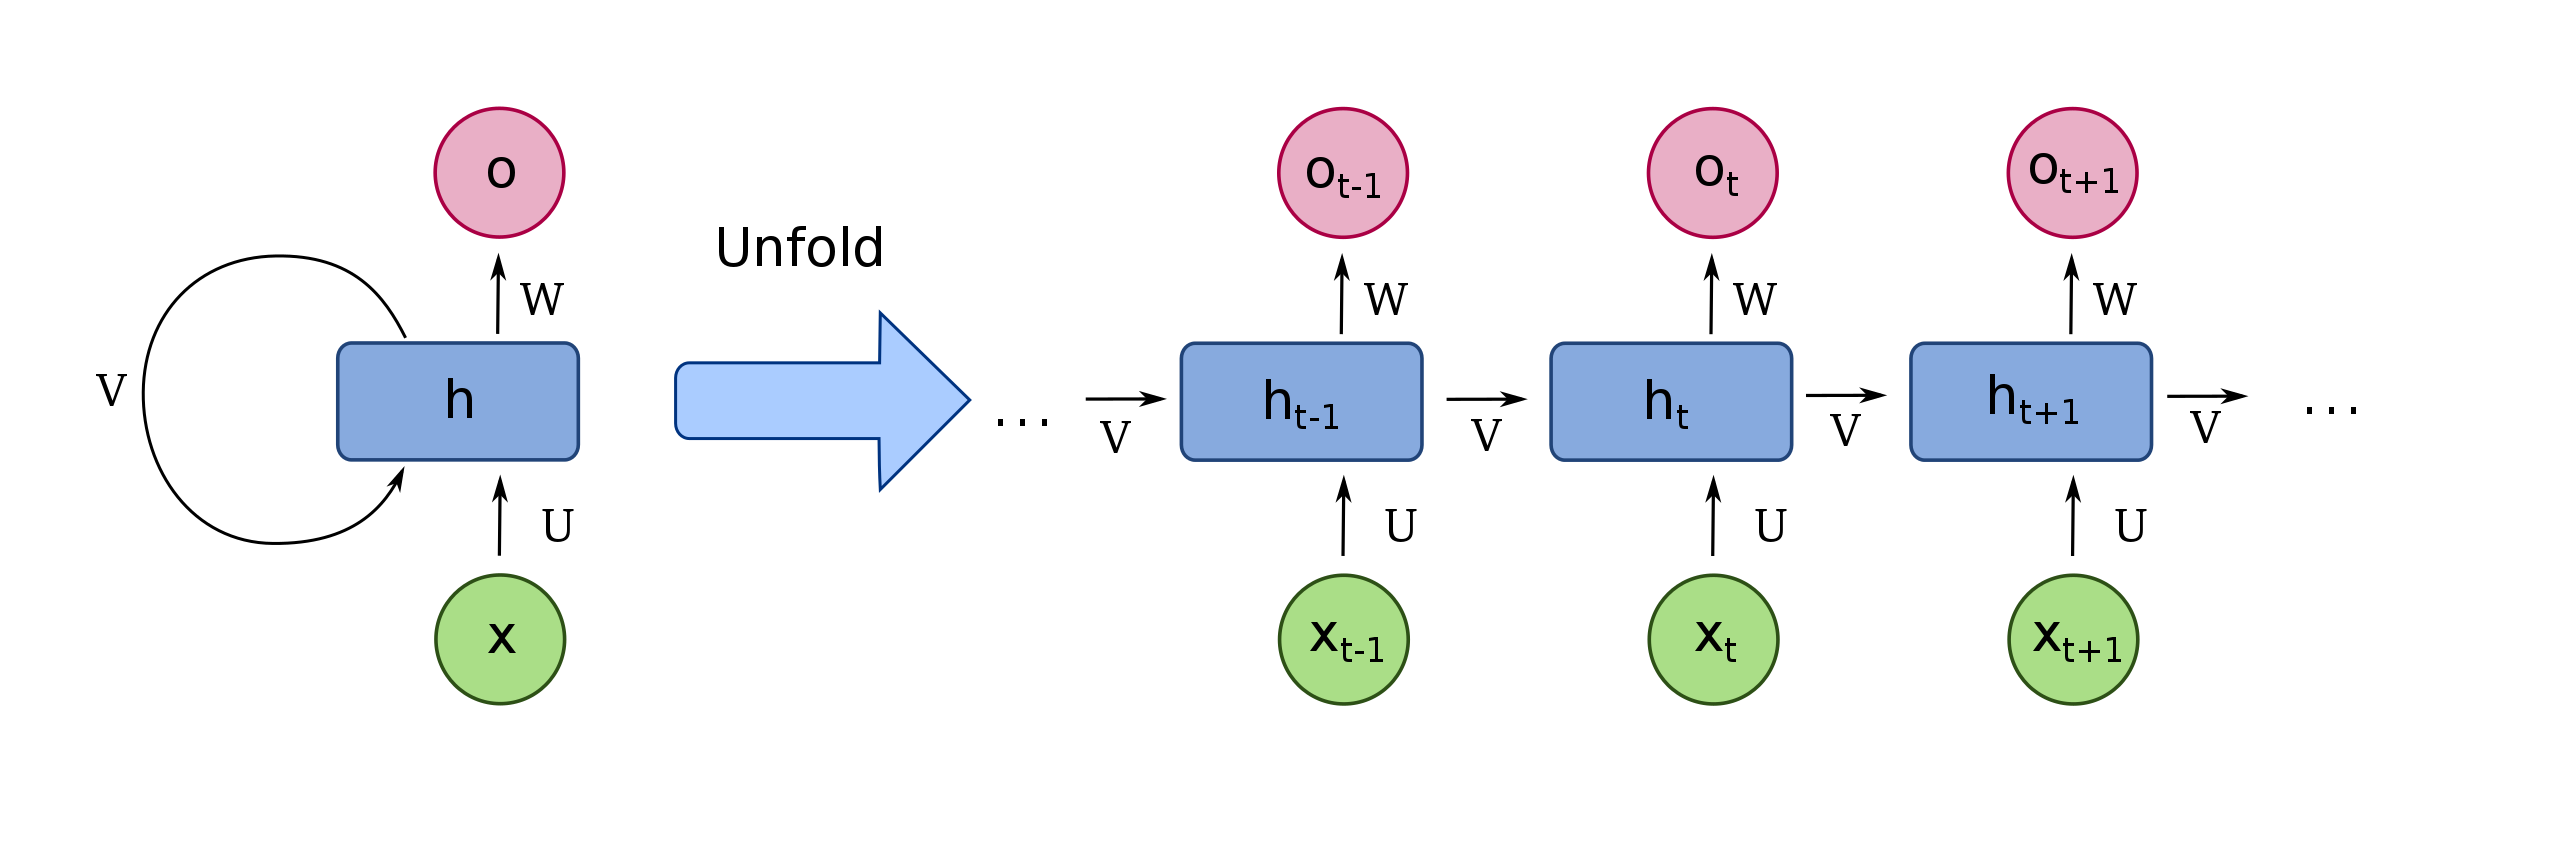

## unpack libraries
if using colab, upload the `material.tgz` and run the next cell

In [ ]:
!tar -xvzf material.tgz

## 1. Load necessary libraries

In [ ]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
import collections
import time

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')
from utils import gr_disp

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

## 2. Load the text data

In [ ]:
def read_data(fname):
    with open(fname) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [word for i in range(len(content)) for word in content[i].split()]
    content = np.array(content)
    return content

In [ ]:
training_file = 'RNN/rnn.txt'

In [ ]:
training_data = read_data(training_file)

In [ ]:
print(training_data[:100])

## 3. Build dataset
We will assign an id to each word, and make dictionaries word->id and id->word.
The most frequently repeating words have lowest id

In [ ]:
def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

In [ ]:
dictionary, reverse_dictionary = build_dataset(training_data)
vocab_size = len(dictionary)

In [ ]:
print(dictionary)

Then the whole text will look as a sequence of word ids:

In [ ]:
print([dictionary[w] for w in training_data])

## 4. Build model

In [ ]:
# Parameters
learning_rate = 0.001
training_iters = 100000
display_step = 1000
n_input = 5

# number of units in RNN cell
n_hidden = [1024, 512]

def RNN(x, n_vocab, n_hid):
    x = tf.unstack(x, n_input, 1)

    basic_cells = [tf.nn.rnn_cell.LSTMCell(n) for n in n_hid]
    rnn_cell = tf.nn.rnn_cell.MultiRNNCell(basic_cells)
    
    # generate prediction
    outputs, states = tf.nn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # there are n_input outputs but
    # we only want the last output
    last_output = outputs[-1]
    
    w = tf.Variable(tf.random_normal([n_hid[-1], n_vocab]))
    b = tf.Variable(tf.random_normal([n_vocab]))
    y = tf.matmul(last_output, w) + b
    return y

                    
g = tf.Graph()
with g.as_default():
    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocab_size])
    
    pred = RNN(x, vocab_size, n_hidden)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
gr_disp.show(g.as_graph_def())

## 5. Run!

In [ ]:
with tf.Session(graph=g) as session:
    session.run(tf.global_variables_initializer())
    step = 0
    offset = np.random.randint(0,n_input+1)
    end_offset = n_input + 1
    acc_total = 0
    loss_total = 0

    start_time = time.time()
    while step < training_iters:
        # Generate a minibatch. Add some randomness on selection process.
        if offset > (len(training_data)-end_offset):
            offset = np.random.randint(0, n_input+1)

        symbols_in_keys = [ [dictionary[ str(training_data[i])]] for i in range(offset, offset+n_input) ]
        symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

        symbols_out_onehot = np.zeros([vocab_size], dtype=float)
        symbols_out_onehot[dictionary[str(training_data[offset+n_input])]] = 1.0
        symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

        _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
        loss_total += loss
        acc_total += acc
        if (step+1) % display_step == 0:
            print("Iter= " + str(step+1) + ", Average Loss= " + \
                  "{:.6f}".format(loss_total/display_step) + ", Average Accuracy= " + \
                  "{:.2f}%".format(100*acc_total/display_step))
            acc_total = 0
            loss_total = 0
            symbols_in = [training_data[i] for i in range(offset, offset + n_input)]
            symbols_out = training_data[offset + n_input]
            symbols_out_pred = reverse_dictionary[int(tf.argmax(onehot_pred, 1).eval())]
            print("%s - [%s] vs [%s]" % (symbols_in,symbols_out,symbols_out_pred))
        step += 1
        offset += (n_input+1)
    print("Optimization Finished!")
    print("Elapsed time: ", time.time() - start_time)

    
    for itr in range(100):
        prompt = "%s words: " % n_input
        sentence = input(prompt)
        sentence = sentence.strip()
        words = sentence.split(' ')
        if len(words) != n_input:
            continue
        try:
            symbols_in_keys = [dictionary[str(words[i])] for i in range(len(words))]
            for i in range(128):
                keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])
                onehot_pred = session.run(pred, feed_dict={x: keys})
                onehot_pred_index = int(tf.argmax(onehot_pred, 1).eval())
                sentence = "%s %s" % (sentence,reverse_dictionary[onehot_pred_index])
                symbols_in_keys = symbols_in_keys[1:]
                symbols_in_keys.append(onehot_pred_index)
            print(sentence)
        except:
            print("Word not in dictionary")

## 6. Excercice 
* Run with 5-7 input words instead of 3.
* increase number of training iterations, since convergance will take much longer (training as well!).

## 7. Further reading

[Illustrated Guide to Recurrent Neural Networks](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9)

[Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)